### Konwersja

In [1]:
import pandas as pd
import os

input_folder = "data"
output_folder = "data_converted"

os.makedirs(output_folder, exist_ok=True)

for file in os.listdir(input_folder):
    if file.endswith(".csv"):
        input_path = os.path.join(input_folder, file)
        output_path = os.path.join(output_folder, file.replace(".csv", "_converted.csv"))

        data = pd.read_csv(input_path)

        data['sex'] = data['sex'].map({'female': 0, 'male': 1})
        data['smoker'] = data['smoker'].map({'no': 0, 'yes': 1})
        data = pd.get_dummies(data, columns=['region'], drop_first=True)

        data.to_csv(output_path, index=False)
        print(f"Zapisano: {output_path}")

print("Wszystkie pliki zostały przekonwertowane")


Zapisano: data_converted\insurance_cleaned_knn_converted.csv
Zapisano: data_converted\insurance_cleaned_mean_median_converted.csv
Zapisano: data_converted\insurance_cleaned_regression_converted.csv
Zapisano: data_converted\insurance_cleaned_sklearn_impute_converted.csv


KeyError: "None of [Index(['region'], dtype='object')] are in the [columns]"

### Wizualizacja zmiennych numerycznych

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data_converted/insurance_cleaned_knn_converted.csv")
df.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19.0,0,27.900000,0.0,1,16884.9240,False,False,True
1,18.0,1,33.770000,0.0,0,1725.5523,False,True,False
2,28.0,1,33.000000,3.0,0,4449.4620,False,True,False
3,33.0,1,32.046667,0.0,0,12406.0841,True,False,False
4,32.0,1,28.880000,0.0,0,3866.8552,True,False,False


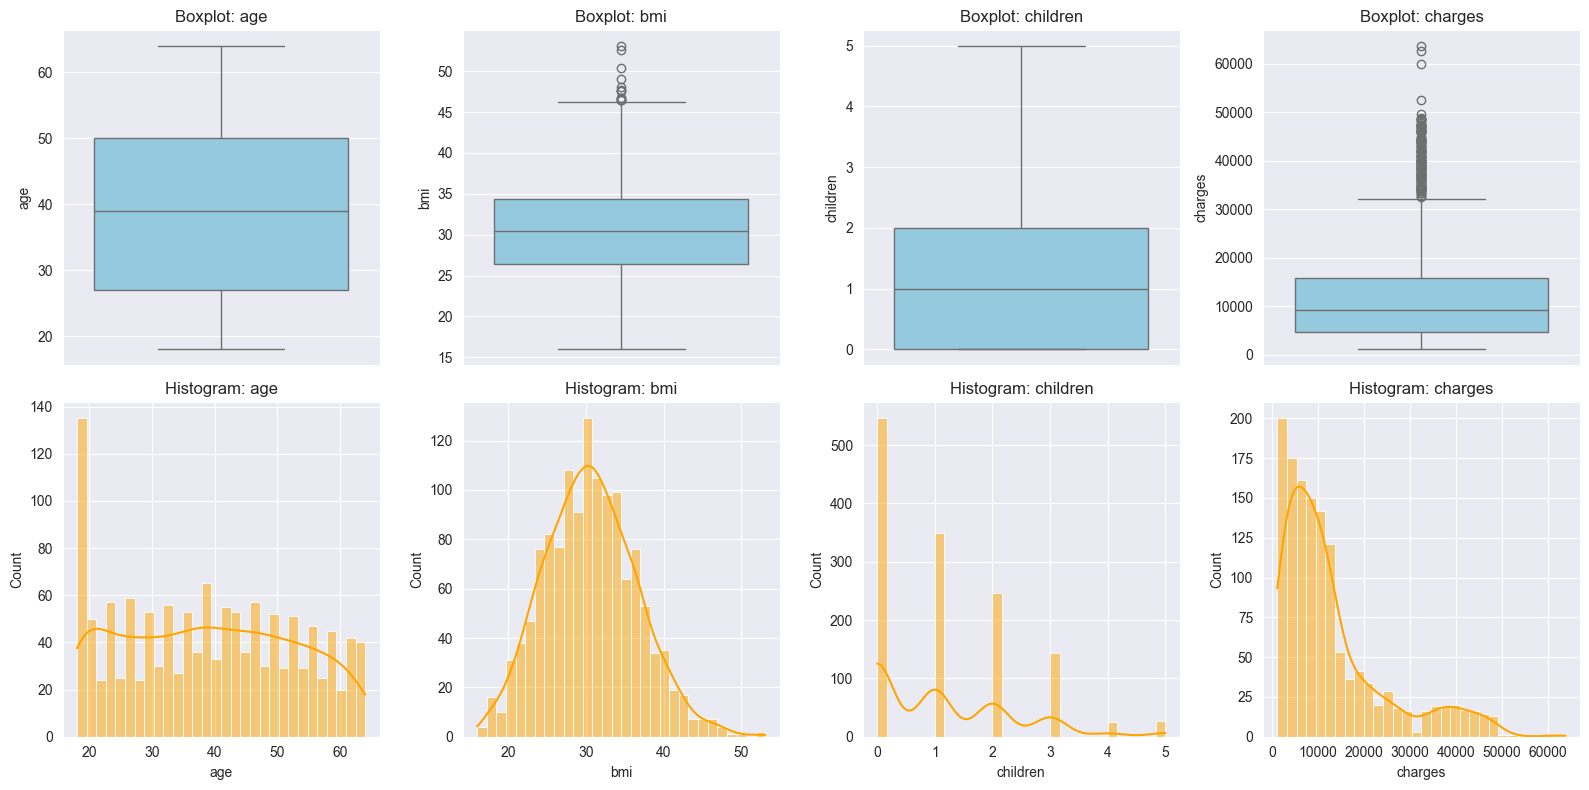

In [5]:
num_cols = ['age', 'bmi', 'children', 'charges']

fig, axes = plt.subplots(2, len(num_cols), figsize=(16, 8))

for i, col in enumerate(num_cols):
    sns.boxplot(df[col], ax=axes[0, i], color="skyblue")
    axes[0, i].set_title(f"Boxplot: {col}")

    sns.histplot(df[col], ax=axes[1, i], bins=30, kde=True, color="orange")
    axes[1, i].set_title(f"Histogram: {col}")

plt.tight_layout()
plt.show()

### Identyfikacja outlierów metodą IQR

Q1 – 25% danych jest mniejszych lub równych tej wartości

Q3 – 75% danych jest mniejszych lub równych tej wartości

IQR jest miarą rozproszenia środkowej części danych i jest używany do wykrywania outlierów.

Q1−1.5∗IQR lub powyżej lub Q3+1.5∗IQR to potencjalny outlier.

In [6]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if lower_bound < 0:
        lower_bound = 0

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

for col in num_cols:
    outliers, low, high = detect_outliers_iqr(df, col)
    print(f"\n{col}: {len(outliers)} wartości odstających")
    print(f"Zakres dopuszczalny: {low:.2f} – {high:.2f}")


age: 0 wartości odstających
Zakres dopuszczalny: 0.00 – 84.50

bmi: 13 wartości odstających
Zakres dopuszczalny: 14.43 – 46.38

children: 0 wartości odstających
Zakres dopuszczalny: 0.00 – 5.00

charges: 139 wartości odstających
Zakres dopuszczalny: 0.00 – 32328.13


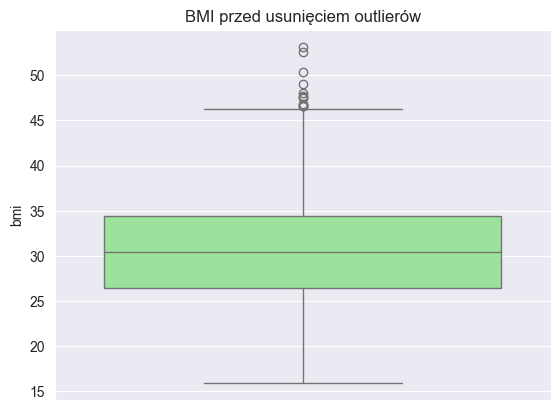

In [7]:
sns.boxplot(df['bmi'], color='lightgreen')
plt.title("BMI przed usunięciem outlierów")
plt.show()

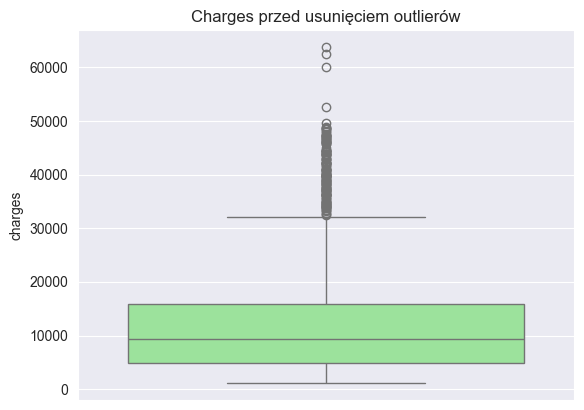

In [8]:
sns.boxplot(df['charges'], color='lightgreen')
plt.title("Charges przed usunięciem outlierów")
plt.show()

In [9]:
df_cleaned_files = {}

converted_folder = "data_converted"

df_cleaned_files = {}

for file in os.listdir(converted_folder):
    if file.endswith("_converted.csv"):
        file_path = os.path.join(converted_folder, file)
        df = pd.read_csv(file_path)

        before = df.shape[0]
        df_cleaned = df[(df['bmi'] >= 15) & (df['bmi'] <= 50)]
        after = df_cleaned.shape[0]

        print(f"{file}: Usunięto {before - after} wierszy ({(before - after)/before:.2%}) z powodu BMI outlierów.")

        df_cleaned_files[file.replace("_converted.csv", "")] = df_cleaned

print("Wszystkie pliki zostały oczyszczone z outlierów BMI.")

insurance_cleaned_knn_converted.csv: Usunięto 3 wierszy (0.22%) z powodu BMI outlierów.
insurance_cleaned_mean_median_converted.csv: Usunięto 3 wierszy (0.22%) z powodu BMI outlierów.
insurance_cleaned_regression_converted.csv: Usunięto 3 wierszy (0.22%) z powodu BMI outlierów.
insurance_cleaned_sklearn_impute_converted.csv: Usunięto 3 wierszy (0.22%) z powodu BMI outlierów.
Wszystkie pliki zostały oczyszczone z outlierów BMI.


### Wnioski

- Oficjalne zakresy BMI (WHO — World Health Organization) - <16 to wygłodzenie, powyzej 50 to ekstremalna otyłość. Usunęliśmy wartości które były skrajnymi wynikami

- nie usuwaliśmy outlierów w kolumnie 'charges', ponieważ koszty ubezpieczenia mogą być naturalnie wysokie dla niektórych grup (np. palacze, starsi ludzie)

### Analiza cech

| Cecha      | Typ                  | Opis                                               | Wnioski                                     |
|------------|---------------------|---------------------------------------------------|---------------------------------------------|
| age        | numeryczna (ciągła) | Wiek ubezpieczonego                                | Skalować                                    |
| sex        | kategoryczna binarna| Płeć                                              |  0/1, zostawić                    |
| bmi        | numeryczna (ciągła) | Wskaźnik masy ciała                               | Skalować                                    |
| children   | numeryczna dyskretna| Liczba dzieci - Liczby te są niewielkie i nie mają szerokiego rozrzutu | Można skalować                              |
| smoker     | kategoryczna binarna| Czy osoba pali                                    | Zostawić, kluczowa cecha                    |
| charges    | numeryczna (cel)    | Koszty ubezpieczenia                               | Zmienna docelowa |
| region     | kategoryczna (dummy)| Region zamieszkania                               | Zostawić, może pomóc w modelu               |


### Skalowanie cech numerycznych

In [19]:
output_folder = "data_scaled"
os.makedirs(output_folder, exist_ok=True)

num_cols = ['age', 'bmi', 'children']

def min_max_scale(series):
    min_val = series.min() # Znajdź najmniejszą wartość w kolumnie
    max_val = series.max() # Znajdź największą wartość w kolumnie
    return (series - min_val) / (max_val - min_val)

def standard_scale(series):
    mean_val = series.mean() # Średnia wszystkich wartości
    std_val = series.std(ddof=0) # Odchylenie standardowe
    return (series - mean_val) / std_val

Skalowanie danych – Min-Max i Standaryzacja (Z-score)

W analizie danych i uczeniu maszynowym często przekształca się wartości cech liczbowych, aby znajdowały się w określonym zakresie lub miały określone właściwości. Takie przekształcenia nazywamy normalizacją lub skalowaniem danych.

1. Normalizacja Min-Max

Dopasowanie wartości cechy do zadanego zakresu, najczęściej [0,1].

$X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$

2 Standaryzacja (Z-score)

Przekształca dane tak, aby miały średnią = 0 i odchylenie standardowe = 1.

$X_{\text{scaled}} = \frac{X - \mu}{\sigma}$





In [22]:
for name, df in df_cleaned_files.items():
    df_minmax = df.copy()
    df_standard = df.copy()

    for col in num_cols:
        df_minmax[col] = min_max_scale(df_minmax[col])

    for col in num_cols:
        df_standard[col] = standard_scale(df_standard[col])

    minmax_path = os.path.join(output_folder, f"{name}_minmax_scaled.csv")
    standard_path = os.path.join(output_folder, f"{name}_standard_scaled.csv")

    df_minmax.to_csv(minmax_path, index=False)
    df_standard.to_csv(standard_path, index=False)

    print(f"Zapisano: {minmax_path}")
    print(f"Zapisano: {standard_path}")

print("\nWszystkie zbiory zostały przeskalowane i zapisane do folderu data_scaled/")

Zapisano: data_scaled\insurance_cleaned_knn_minmax_scaled.csv
Zapisano: data_scaled\insurance_cleaned_knn_standard_scaled.csv
Zapisano: data_scaled\insurance_cleaned_mean_median_minmax_scaled.csv
Zapisano: data_scaled\insurance_cleaned_mean_median_standard_scaled.csv
Zapisano: data_scaled\insurance_cleaned_regression_minmax_scaled.csv
Zapisano: data_scaled\insurance_cleaned_regression_standard_scaled.csv
Zapisano: data_scaled\insurance_cleaned_sklearn_impute_minmax_scaled.csv
Zapisano: data_scaled\insurance_cleaned_sklearn_impute_standard_scaled.csv

Wszystkie zbiory zostały przeskalowane i zapisane do folderu data_scaled/


In [18]:
import pandas as pd
import os

original_path = "data_converted/insurance_cleaned_knn_converted.csv"
minmax_path = "data_scaled/insurance_cleaned_knn_minmax_scaled.csv"
standard_path = "data_scaled/insurance_cleaned_knn_standard_scaled.csv"

df_original = pd.read_csv(original_path)
df_minmax = pd.read_csv(minmax_path)
df_standard = pd.read_csv(standard_path)

num_cols = ['age', 'bmi', 'children']

print("Oryginalne dane:")
df_original[num_cols].head(10)


Oryginalne dane:


,age,bmi,children
0,19.0,27.900000,0.0
1,18.0,33.770000,0.0
2,28.0,33.000000,3.0
3,33.0,32.046667,0.0
4,32.0,28.880000,0.0
5,31.0,36.300000,0.0
6,46.0,33.440000,1.0
7,37.0,27.740000,3.0
8,37.0,29.830000,2.0
9,60.0,25.840000,0.0


In [16]:
print("\nDane po skalowaniu Min-Max:")
df_minmax[num_cols].head(10)



Dane po skalowaniu Min-Max:


,age,bmi,children
0,0.021739,0.360725,0.0
1,0.000000,0.538066,0.0
2,0.217391,0.514804,0.6
3,0.326087,0.486002,0.0
4,0.304348,0.390332,0.0
5,0.282609,0.614502,0.0
6,0.608696,0.528097,0.2
7,0.413043,0.355891,0.6
8,0.413043,0.419033,0.4
9,0.913043,0.298489,0.0


In [17]:
print("\nDane po skalowaniu Standard (Z-score):")
(df_standard[num_cols].head(10))


Dane po skalowaniu Standard (Z-score):


,age,bmi,children
0,-1.466365,-0.456970,-0.921845
1,-1.539772,0.542277,-0.921845
2,-0.805700,0.411200,1.528049
3,-0.438664,0.248915,-0.921845
4,-0.512071,-0.290145,-0.921845
5,-0.585478,0.972957,-0.921845
6,0.515631,0.486101,-0.105214
7,-0.145034,-0.484206,1.528049
8,-0.145034,-0.128427,0.711417
9,1.543333,-0.807642,-0.921845
